# First LSTM Model
Author: Camilla Billari <br> 
Date: 19/01/24

Fitting my first LSTM to the Marone p4581 experiment.

In [4]:
# Import relevant libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm

# Change local path
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

In [5]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(f"Total GPUs available: {torch.cuda.device_count()}")  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.") 

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

No GPU available.


## Load Data

In [6]:
# Directories paths
GTC_DATA_DIR = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/data/gtc_quakes_data"
LABQUAKES_DATA_DIR = f"{GTC_DATA_DIR}/labquakes"
DATA_DIR = f"{LABQUAKES_DATA_DIR}/Marone"
EXP = "p4581"

# Open experiment in a dataframe
EXP_FILE_PATH = f"{DATA_DIR}/{EXP}/{EXP}.txt"

In [8]:
# Access experiment and output dataframe head using Pritt's data loaders (which utilises Adriano's loading + pre-processing)
dataset = SlowEarthquakeDataset([EXP])
dataset.load()

# Extract optupts (X, Y, t)
ds_exp = dataset[EXP]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Create dataframe from outputs
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

print("N samples: {}".format(len(df)))
df.head()

N samples: 200010


,det_shear_stress,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,0.002811,1.29911,2.99288,NaN,NaN,0.000
1,0.002731,1.29903,2.99008,NaN,NaN,0.001
2,0.002231,1.29853,2.98854,NaN,NaN,0.002
3,0.002411,1.29871,2.98849,NaN,NaN,0.003
4,0.002241,1.29854,2.99069,NaN,NaN,0.004


### Creating the datastet

In [9]:
# Extract time series data
timeseries = np.array(df["det_shear_stress"])

# Define train-test split proportions
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size

# Perform train-test split
train, test = timeseries[:train_size], timeseries[train_size:]

In [10]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: Numpy array of time series (first dimension is the time steps).
        lookback: Size of the window for prediction.
        forecast: Number of time steps to predict into the future.
    Return:
        X_tensor: Pytorch tensor of the X windowed features
        y_tensor: Pytorch tensor of the y windowed targets
    """
    X, y = [], []

    # Create input features (X) and corresponding targets (y) for prediction
    for i in range(len(dataset) - lookback - forecast + 1):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)

    # Convert the lists to PyTorch tensors - note list->arrays->tensors is faster than list->tensors
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [11]:
# Define lookback and forecast values
lookback, forecast = 10, 1

# Create training and testing dataset
X_train, y_train = create_dataset(train, lookback, forecast)
X_test, y_test = create_dataset(test, lookback, forecast)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([159998, 10]), torch.Size([159998, 1])
Testing data shapes: torch.Size([39992, 10]), torch.Size([39992, 1])


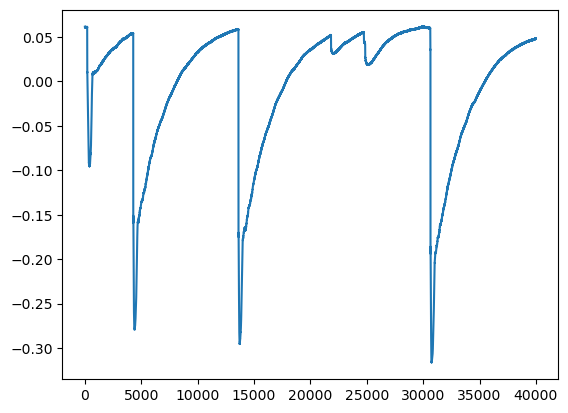

In [16]:
# Plot 3rd X_test window
plt.plot(X_test[:, 2])

## Modelling

In [17]:
import torch.nn as nn

# Define the number of input variates and hidden size
n_variates = 1
hidden_size = 50

class AirModel(nn.Module):
    """ Subclass of nn.Module """
    def __init__(self):
        super().__init__()

        # LSTM layer with specified input size, hidden size, and batch_first
        self.lstm = nn.LSTM(
            input_size=n_variates,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Linear layer mapping the LSTM output to the forecasted values
        self.linear = nn.Linear(hidden_size, forecast)

    def forward(self, x):
        """ Forward pass through the LSTM layer. """
        x, _ = self.lstm(x)
        x = x[:, -1, :] # extract the last time step output from the LSTM output
        x = self.linear(x) # linear layer for the final output (forecasted values)
        return x

### Training

In [18]:
# Move training and testing data to the specified device (cuda or cpu)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
import torch.optim as optim
import torch.utils.data as data

# Instantiate the AirModel and move it to the specified device
model = AirModel().to(device)

# Define Adam optimizer and Mean Squared Error (MSE) loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create a DataLoader for training batches
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32
)

# Set the number of training epochs
n_epochs = 200
pbar = tqdm.tqdm(range(n_epochs))

# Training loop
for epoch in pbar:
    model.train()

    # Iterate through batches in the DataLoader
    for X_batch, y_batch in loader:
        # print("X_batch: {}, y_batch: {}".format(X_batch.shape, y_batch.shape))
        # print("y_batch: {}".format(y_batch.shape))
        y_pred = model(X_batch.unsqueeze(-1)) # reshape input for univariate (add a dimension)
        # print("y_pred: {}".format(y_pred.shape))
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation every 100 epochs
    if epoch % 100 != 0:
        continue

    model.eval()

    with torch.no_grad():
        # Evaluate model on training data
        y_pred = model(X_train.unsqueeze(-1))
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Evaluate model on testing data
        y_pred = model(X_test.unsqueeze(-1))
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))

    # Update progress bar with training and testing RMSE
    pbar.set_description(
            f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
        )

## Results

In [ ]:
with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan

    # Get predictions for training data and fill the plot array
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan

    # Get predictions for testing data and fill the plot array
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# Plotting
plt.plot(timeseries, c="b")
plt.plot(train_plot, c="r")
plt.plot(test_plot, c="g")
plt.show()